[View in Colaboratory](https://colab.research.google.com/github/Tzeny/cifar100/blob/master/Cifar100.ipynb)

This is my attempt at solving the Cifar100 challenge. This file is also available on GitHub: [https://github.com/Tzeny/cifar100/blob/master/Cifar100.ipynb](https://github.com/Tzeny/cifar10/blob/master/Cifar100.ipynb)



|Nr. crt.|Model architecture | Optimizer | Batch size  | Train images | Stop epoch | Test accuracy |
|---||------------- |---|-------------|----|
|2|3 x inception(w dr (image net feature counts)) avg flt 2 x dense (w dr) act \[w batch normalization\]|Adam(0.001)|128|Normalized color |31|~39.58 %

>[Google Colab ensure we have our own GPU](#scrollTo=nZ-oiI4YlXGL)

>[Connecting to Google Drive](#scrollTo=sqKMRov-lQjI)

>[Prepare our dataset](#scrollTo=l-LAEOiUmMgt)

>[Model definition and training](#scrollTo=xmoQDAurmSbS)

>[Model evaluation](#scrollTo=f53m3bg_p5rk)



# Google Colab ensure we have our own GPU

In [4]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.6 GB  | Proc size: 139.9 MB
GPU RAM Free: 11438MB | Used: 1MB | Util   0% | Total 11439MB


In [0]:
 !kill -9 -1

# Connecting to Google Drive

In [2]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p my_drive
!google-drive-ocamlfuse my_drive
!ls my_drive/ai


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.
kaggle	projects


# Prepare our dataset

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

np.random.seed(451)

from keras.datasets import cifar100

(X_train, y_train), (X_test, y_test) = cifar100.load_data()

# print shape of data while model is building
print("{1} train samples, {2} channel{0}, {3}x{4}".format("" if X_train.shape[1] == 1 else "s", *X_train.shape))
print("{1}  test samples, {2} channel{0}, {3}x{4}".format("" if X_test.shape[1] == 1 else "s", *X_test.shape))

#capital letter values will be used for the generators
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, y_train, test_size=0.2)

Y_train_cat = to_categorical(Y_train)
Y_test_cat = to_categorical(y_test)
Y_valid_cat = to_categorical(Y_valid)

50000 train samples, 32 channels, 32x3
10000  test samples, 32 channels, 32x3


In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
  
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xvf cifar-100-python.tar.gz

--2018-07-13 12:50:40--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  1.36MB/s    in 2m 24s  

2018-07-13 12:53:05 (1.12 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


In [4]:
!pwd

/home/tzeny/Other/Projects/Keras/cifar100


In [5]:
train = unpickle('cifar-100-python/train')
test = unpickle('cifar-100-python/test')

meta = unpickle('cifar-100-python/meta')

In [6]:
classes = meta[b'fine_label_names']

In [8]:
print(X_train.shape,X_valid.shape,X_test.shape)
print(Y_train_cat.shape,Y_valid_cat.shape,Y_test_cat.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 100) (10000, 100) (10000, 100)


b'plain'


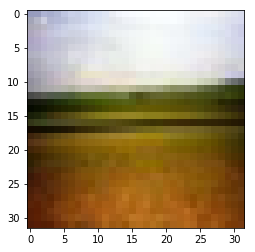

In [10]:
import random
i = random.randint(0,10000)

print(classes[np.argmax(Y_valid_cat[i])])
plt.imshow(X_valid[i])

In [61]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

generator = ImageDataGenerator(rescale = 1./255 )

valid = generator.flow(X_valid,
                       Y_valid_cat,
                       batch_size = batch_size)

test = generator.flow(X_test,
                      Y_test_cat,
                      batch_size = batch_size)

generator2 = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 20,
                               shear_range = 0.3,
                               zoom_range = 0.3,
                               horizontal_flip = True)

train = generator2.flow(X_train,
                        Y_train_cat,
                        batch_size = batch_size)

b'train'


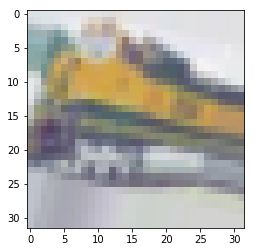

In [62]:
image, label = train.next()

print(classes[np.argmax(label[0])])
plt.imshow(image[0])

# Model definition and training

In [64]:
np.random.seed(451)

import datetime
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K


i='cifar100-nrcrt3-'+datetime.datetime.now().strftime("%I:%M%p_%B-%d-%Y")

K.clear_session()

!mkdir -p models
!mkdir -p logs

a = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')#will stop the model if val_loss does not improve for 2 consecutive epochs
b = ModelCheckpoint(monitor='val_loss', filepath='./models/'+str(i)+'.hdf5', verbose=1, save_best_only=True)#save model weights after each epoch if val_loss improves
c = TensorBoard(log_dir='./logs/'+str(i),
                write_grads=True,
                write_graph=True,
                write_images=True,
                batch_size=128)#saves a log file for tensorboard; remember to save different runs to different subdirectories

#we'll use this instead of decay
d = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[a,b,c,d]

#------------model definition-------------------

input_tensor = Input(shape=(32, 32, 3))  # this assumes K.image_data_format() == 'channels_last'


# create the base pre-trained model
base_model = Xception(input_tensor=input_tensor, weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes

x = Dense(256, activation='relu')(x)

x = Dense(128, activation='relu')(x)

predictions = Dense(100, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#-----------------------------------------------

#model.compile(loss='categorical_crossentropy',
#              optimizer=Adam(lrate),
#              metrics=['accuracy'])

model.summary()

#model_json = model.to_json()
#with open("./models/"+str(i)+".json", "w") as json_file:
#    json_file.write(model_json)

#print("Saved model to" + "../models/"+str(i)+".json")


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 15, 15, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 15, 15, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 15, 15, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [65]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes
  
print("Memory usage (GB):", get_model_memory_usage(32,model))

Memory usage (GB): 2.823


In [66]:
import tensorflow as tf

with tf.device('/gpu:0'):
      model.fit_generator(generator=train,
                      validation_data=valid,
                      steps_per_epoch=2000,
                      epochs=50,
                      verbose=1,callbacks=callbacks)  # starts training

result = model.evaluate_generator(test)

print("Accuracy on test set: ",result[1]*100,"%")

#copy our generated model and logs to GoogleDrive
#!cp -R models my_drive/ai/projects/cifar100
#!cp -R logs my_drive/ai/projects/cifar100

print("Copied model and logs to Google Drive")

Epoch 1/50
1171/2000 [================>.............] - ETA: 1:34 - loss: 4.5937 - acc: 0.0190

KeyboardInterrupt: 

# Model evaluation

In [1]:
model.load_weights('./models/cifar100-nrcrt2-11:15AM_July-12-2018.hdf5')

result = model.evaluate_generator(test)

print(result)

NameError: ignored